In [14]:
# ==========================================================
# Evaluation script: Surface code d=3 (Astra GNN decoder)
# - Rebuilds code + GNN with same hyperparams as training
# - Loads checkpoint
# - Sweeps over PER and computes LER via logical_error_rate
# - Optional stub for BP+OSD baseline via PanQEC
# ==========================================================

import os
import time
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from panqec.codes import surface_2d
from panqec.error_models import PauliErrorModel
from panqec.decoders import BeliefPropagationOSDDecoder, MatchingDecoder


from ldpc.mod2 import nullspace

from panq_functions import (
    GNNDecoder,
    collate,
    generate_syndrome_error_volume,
    adapt_trainset,
    logical_error_rate,
    fraction_of_solved_puzzles,
    surface_code_edges,
    load_model,
)

# ------------------------------------------
# Device selection: MPS (Mac GPU)  → CPU
# ------------------------------------------
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print("Using device:", device)

# ==========================================================
# Parameters (must match training!)
# ==========================================================

d = 3
error_model_name = "DP"

# same DP error model as in training
error_model = PauliErrorModel(0.34, 0.32, 0.34)

n_node_inputs = 4
n_node_outputs = 4
n_iters = 3
n_node_features = 50
n_edge_features = 50
msg_net_size = 512
msg_net_dropout_p = 0.05
gru_dropout_p = 0.05

# list of physical error rates to test
err_rates = np.array([0.06, 0.08, 0.10, 0.12, 0.14, 0.16])

# number of test samples at each PER
base_test_samples = 2000   # you can increase later if it’s fast


Using device: mps


In [ ]:
# ==========================================================
# Build code and GNN (same architecture as training)
# ==========================================================

code = surface_2d.RotatedPlanar2DCode(d)

gnn = GNNDecoder(
    dist=d,
    n_node_inputs=n_node_inputs,
    n_node_outputs=n_node_outputs,
    n_iters=n_iters,
    n_node_features=n_node_features,
    n_edge_features=n_edge_features,
    msg_net_size=msg_net_size,
    msg_net_dropout_p=msg_net_dropout_p,
    gru_dropout_p=gru_dropout_p,
)
gnn.to(device)

# Tanner graph edges
src, tgt = surface_code_edges(code)
GNNDecoder.surface_code_edges = (
    torch.LongTensor(src),
    torch.LongTensor(tgt),
)

# Degeneracy nullspaces via ldpc.mod2.nullspace
hx_null = nullspace(code.Hx.toarray())
hz_null = nullspace(code.Hz.toarray())

# convert sparse matrices (if any) to dense
try:
    hx_null = hx_null.toarray()
except AttributeError:
    pass
try:
    hz_null = hz_null.toarray()
except AttributeError:
    pass

GNNDecoder.hxperp = torch.tensor(hx_null, dtype=torch.float32, device=device)
GNNDecoder.hzperp = torch.tensor(hz_null, dtype=torch.float32, device=device)

GNNDecoder.device = device


# ==========================================================
# Load trained checkpoint
# ==========================================================

CHECKPOINT_PREFIX = "trained_models/d3_DP_3_50_50_"
CHECKPOINT_FILE   = "gnn_best_20.pth 0.322_0.62"  # <-- edit this string

checkpoint_path = CHECKPOINT_PREFIX + CHECKPOINT_FILE

print("Loading model from:", checkpoint_path)
load_model(gnn, checkpoint_path, device)
gnn.eval()


Loading model from: trained_models/d3_DP_3_50_50_gnn_best_20.pth 0.322_0.62
Model loaded from trained_models/d3_DP_3_50_50_gnn_best_20.pth 0.322_0.62.


GNNDecoder(
  (final_digits): Linear(in_features=50, out_features=4, bias=True)
  (msg_net): Sequential(
    (0): Linear(in_features=100, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.05, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.05, inplace=False)
    (6): Linear(in_features=512, out_features=512, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.05, inplace=False)
    (9): Linear(in_features=512, out_features=50, bias=True)
  )
  (gru): GRU(54, 50)
  (gru_drop): Dropout(p=0.05, inplace=False)
)

In [24]:
# ==========================================================
# Helper: evaluate GNN LER at a given PER
# ==========================================================
def is_logical_error(code, e_true, e_hat):
    """
    Return True iff e_hat differs from e_true by a logical operator.
    """
    d = (e_true ^ e_hat)  # xor difference, shape (2*n,)

    # Dot product mod 2 with logical X/Z operators
    for L in code.logicals_x:
        if (d @ L) % 2 == 1:
            return True
    for L in code.logicals_z:
        if (d @ L) % 2 == 1:
            return True

    return False

def evaluate_gnn_at_p(p, n_samples):
    """
    Generate n_samples at physical error rate p,
    build DataLoader, and compute:
      - fraction of solved syndromes
      - LER_X, LER_Z, LER_tot
    using logical_error_rate from panq_functions.
    """
    print(f"\n[GNn] Evaluating at p = {p:.3f}, N = {n_samples}")

    # generate test set via PanQEC helper
    batch = generate_syndrome_error_volume(
        code, error_model=error_model, p=p,
        batch_size=n_samples, for_training=False
    )
    testset = adapt_trainset(batch, code, num_classes=n_node_inputs, for_training=False)
    testloader = DataLoader(testset, batch_size=512, collate_fn=collate, shuffle=False)

    t1 = time.time()
    frac = fraction_of_solved_puzzles(gnn, testloader, code)
    lerx, lerz, lertot = logical_error_rate(gnn, testloader, code)
    t2 = time.time()

    print(f"  fraction solved: {frac:.4f}")
    print(f"  LER_X={lerx:.5f}, LER_Z={lerz:.5f}, LER_tot={lertot:.5f}, time={t2-t1:.2f}s")

    return frac, lerx, lerz, lertot

def evaluate_bp_osd_panqec(p, N):
    """
    BP+OSD baseline using PanQEC's BeliefPropagationOSDDecoder.
    Returns logical error rate (LER_tot).
    """

    print(f"\n[BP+OSD] Evaluating at p = {p:.3f}, N = {N}")

    p = float(p)
    # error_model.px = float(error_model.px)
    # error_model.py = float(error_model.py)
    # error_model.pz = float(error_model.pz)

    # Draw random Pauli errors
    errors = np.zeros((N, 2 * code.n), dtype='uint8')
    for i in range(N):
        errors[i] = error_model.generate(code, p)

    # Compute syndromes
    syndromes = code.measure_syndrome(errors).T  # shape (N, m)

    # Construct BP+OSD decoder
    bp_osd = BeliefPropagationOSDDecoder(
        code=code,
        error_model=error_model,
        error_rate=float(p),
        osd_order=2,       # OSD order 2 recommended in PanQEC’s docs
        max_bp_iter=10     # BP iterations before OSD
    )
    bp_osd.initialize_decoders()

    n_logical_fail = 0

    for i in range(N):
        e_true = errors[i]
        s = syndromes[i]

        # decode syndrome → candidate error
        e_hat = bp_osd.decode(s)

        # check logical equivalence class
        # PanQEC provides code.logical_x/z operators
        # Logical error means differing by a nontrivial logical operator
        if is_logical_error(code, e_true, e_hat):
            n_logical_fail += 1

    ler = n_logical_fail / N
    print(f"  Logical error rate (BP+OSD): {ler:.5f}")
    return ler

def evaluate_matching_at_p(p, n_samples):
    """
    Baseline decoder using PanQEC's MatchingDecoder (MWPM).

    Computes FRAME ERROR RATE (FER): probability that MWPM fails
    to reconstruct the physical error.
    """

    print(f"\n[MWPM] Evaluating at p = {p:.3f}, N = {N}")

    p = float(p)
    errors = np.zeros((N, 2 * code.n), dtype='uint8')
    for i in range(N):
        errors[i] = error_model.generate(code, p)

    syndromes = code.measure_syndrome(errors).T

    mwpm = MatchingDecoder(code, error_model, error_rate=p)

    n_logical_fail = 0

    for i in range(N):
        e_true = errors[i]
        s = syndromes[i]
        e_hat = mwpm.decode(s)

        if is_logical_error(code, e_true, e_hat):
            n_logical_fail += 1

    ler = n_logical_fail / N
    print(f"  Logical error rate (MWPM): {ler:.5f}")
    return ler





[GNn] Evaluating at p = 0.060, N = 2000
  fraction solved: 0.6025
  LER_X=0.18800, LER_Z=0.42850, LER_tot=0.42850, time=0.87s

[BP+OSD] Evaluating at p = 0.060, N = 2000
  Logical error rate (BP+OSD): 0.38150

[MWPM] Evaluating at p = 0.060, N = 2000
  Logical error rate (MWPM): 0.08550

[GNn] Evaluating at p = 0.080, N = 2000
  fraction solved: 0.4955
  LER_X=0.24550, LER_Z=0.53550, LER_tot=0.53700, time=0.53s

[BP+OSD] Evaluating at p = 0.080, N = 2000
  Logical error rate (BP+OSD): 0.36350

[MWPM] Evaluating at p = 0.080, N = 2000
  Logical error rate (MWPM): 0.11800

[GNn] Evaluating at p = 0.100, N = 2000
  fraction solved: 0.4420
  LER_X=0.30050, LER_Z=0.59750, LER_tot=0.59800, time=0.51s

[BP+OSD] Evaluating at p = 0.100, N = 2000
  Logical error rate (BP+OSD): 0.37500

[MWPM] Evaluating at p = 0.100, N = 2000
  Logical error rate (MWPM): 0.14250

[GNn] Evaluating at p = 0.120, N = 2000
  fraction solved: 0.3595
  LER_X=0.34350, LER_Z=0.67150, LER_tot=0.67200, time=0.56s

[BP+O

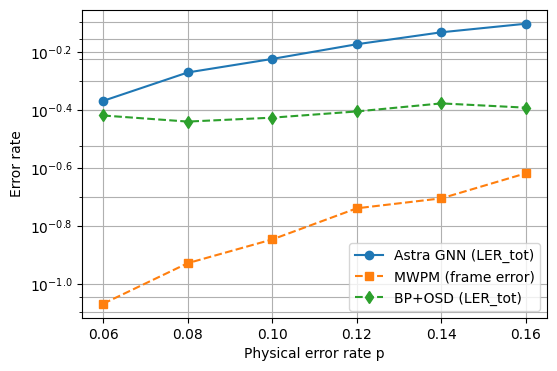

In [30]:
# ==========================================================
# Main sweep over PER, collect curves
# ==========================================================

gnn_lers = []
gnn_lerz = []
gnn_lerx = []
gnn_frac = []
mwpm_fer = []
bp_osd_lers = []

for p in err_rates:
    N = base_test_samples

    frac, lerx, lerz, lertot = evaluate_gnn_at_p(p, N)
    gnn_frac.append(frac)
    gnn_lerx.append(lerx)
    gnn_lerz.append(lerz)
    gnn_lers.append(lertot)

    # BP+OSD baseline
    ler = evaluate_bp_osd_panqec(p, N)
    bp_osd_lers.append(ler)
    # MWPM baseline
    fer = evaluate_matching_at_p(p, N)
    mwpm_fer.append(fer)
    
gnn_lers = np.array(gnn_lers)
mwpm_fer = np.array(mwpm_fer)
bp_osd_lers = np.array(bp_osd_lers)

# ==========================================================
# Plot LER / FER vs PER
# ==========================================================

plt.figure(figsize=(6, 4))
plt.yscale("log")
ticks = [10**x for x in np.arange(-2, 1.1, 0.2)]
plt.gca().set_yticks(ticks)
plt.gca().set_yticklabels([f"$10^{{{np.log10(t):.1f}}}$" for t in ticks])
plt.xlabel("Physical error rate p")
plt.ylabel("Error rate")

plt.plot(err_rates, gnn_lers, "-o", label="Astra GNN (LER_tot)")
plt.plot(err_rates, mwpm_fer, "--s", label="MWPM (frame error)")
plt.plot(err_rates, bp_osd_lers, "--d", label="BP+OSD (LER_tot)")

plt.grid(True, which="both")
plt.legend()